In [31]:
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split #for splitting data
from sklearn.preprocessing import OneHotEncoder # to handle categorical features
from sklearn.compose import ColumnTransformer #for the transormations of one hot encoders
from sklearn.pipeline import Pipeline # for the model pipeline

from sklearn.ensemble import RandomForestClassifier #tree-based classifier

from sklearn.metrics import f1_score, matthews_corrcoef, plot_confusion_matrix, classification_report

# Data 

# Task

To predict the product sales based on the historical records.

In [2]:
data = pd.read_csv("SalesKaggle3.csv")

In [3]:
data

,Order,File_Type,SKU_number,SoldFlag,SoldCount,MarketingType,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice
0,2,Historical,1737127,0.0,0.0,D,15,1,6.827430e+05,44.99,2015,8,28.97,31.84
1,3,Historical,3255963,0.0,0.0,D,7,1,1.016014e+06,24.81,2005,39,0.00,15.54
2,4,Historical,612701,0.0,0.0,D,0,0,3.404640e+05,46.00,2013,34,30.19,27.97
3,6,Historical,115883,1.0,1.0,D,4,1,3.340110e+05,100.00,2006,20,133.93,83.15
4,7,Historical,863939,1.0,1.0,D,2,1,1.287938e+06,121.95,2010,28,4.00,23.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198912,208023,Active,109683,NaN,NaN,D,7,1,2.101869e+05,72.87,2006,54,8.46,60.59
198913,208024,Active,416462,NaN,NaN,D,8,1,4.555041e+05,247.00,2009,65,8.40,74.85
198914,208025,Active,658242,NaN,NaN,S,2,1,1.692746e+05,50.00,2012,23,23.98,32.62
198915,208026,Active,2538340,NaN,NaN,S,2,1,3.775266e+05,46.95,2001,23,27.42,37.89


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198917 entries, 0 to 198916
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Order             198917 non-null  int64  
 1   File_Type         198917 non-null  object 
 2   SKU_number        198917 non-null  int64  
 3   SoldFlag          75996 non-null   float64
 4   SoldCount         75996 non-null   float64
 5   MarketingType     198917 non-null  object 
 6   ReleaseNumber     198917 non-null  int64  
 7   New_Release_Flag  198917 non-null  int64  
 8   StrengthFactor    198917 non-null  float64
 9   PriceReg          198917 non-null  float64
 10  ReleaseYear       198917 non-null  int64  
 11  ItemCount         198917 non-null  int64  
 12  LowUserPrice      198917 non-null  float64
 13  LowNetPrice       198917 non-null  float64
dtypes: float64(6), int64(6), object(2)
memory usage: 21.2+ MB


In [47]:
data['SoldFlag'].value_counts()

0.0    63000
1.0    12996
Name: SoldFlag, dtype: int64

# Data Preprocessing

- We will remove all the unique identifiers like Order, SKU_number etc.

- We gonna use a tree-based model so no need to scale the data. 



In [5]:
def data_preparation(df):
  df = df.copy()

  #only using "Historical" records in File_Type column using query() function
  df = df.query("File_Type == 'Historical'")

  """drop unnecessary columns i.e Unique Identifiers and also File_Type as we only have Horizontal records.
  Remove SoldCount because it is a function for our target SoldFlag i.e we can't give hint to our model so better
  to remove it.
  """
  df = df.drop(["Order", "File_Type", "SKU_number", "SoldCount"], axis=1)

  #Split the data
  X = df.drop("SoldFlag", axis=1)
  y = df['SoldFlag']

  X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, shuffle=True, random_state=1)

  return X_train, X_test, y_train, y_test

In [6]:
 X_train, X_test, y_train, y_test = data_preparation(data)

In [7]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

53197
22799
53197
22799


In [8]:
X_train

,MarketingType,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice
68170,S,8,1,2366193.0,59.20,2002,33,36.46,35.33
73351,S,4,1,296789.0,30.00,1997,25,0.00,26.52
11491,D,4,1,468217.0,21.92,2004,116,95.86,18.94
16183,D,1,0,3568256.0,79.95,1999,21,74.95,44.39
72068,S,3,1,471953.0,181.95,2003,27,0.00,67.81
...,...,...,...,...,...,...,...,...,...
20609,D,8,1,40841.0,103.24,2010,48,99.50,115.55
21440,D,0,0,1611172.0,86.64,2011,19,55.19,78.38
73349,S,2,1,1628317.0,69.99,2004,43,4.02,30.43
50057,S,2,1,1660915.0,44.00,2004,32,34.51,10.12


In [9]:
y_test

37862    0.0
35304    0.0
26138    0.0
52327    0.0
6038     0.0
        ... 
3415     0.0
19907    0.0
22150    0.0
11746    0.0
63219    0.0
Name: SoldFlag, Length: 22799, dtype: float64

# Build the Pipeline for Model Training

- One hot encoder for MarketType and ReleaseNumber.

- Pipeline for defining the steps

In [10]:
def model_pipeline():
    binary_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False, drop='if_binary'))
    ])
    
    nominal_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer(transformers=[
        ('binary', binary_transformer, ['MarketingType']),
        ('nominal', nominal_transformer, ['ReleaseNumber'])
    ], remainder='passthrough')
    
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=1))
    ])
    
    return model

In [11]:
!pip3 install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.1)


In [12]:
train_model = model_pipeline()
clf = train_model.fit(X_train, y_train)

## Evaluation

In [41]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [46]:
# Evaluation on the train set
print("Evaluation on training set \n")
print("--------------------------------------")
model_train_f1 = f1_score(y_train, y_train_pred, average='binary')
print("The f1-score for the training set is: ", np.round(model_train_f1*100), "%")
print("--------------------------------------")

model_train_score = clf.score(X_train, y_train)
print("Model score on the train set is: ", np.round(model_train_score*100), "%")
print("--------------------------------------")

model_train_mcc = matthews_corrcoef(y_train, y_train_pred)
print("Model MCC on the test set is: ", np.round(model_train_mcc*100), "%")

Evaluation on training set 

--------------------------------------
The f1-score for the training set is:  100.0 %
--------------------------------------
Model score on the train set is:  100.0 %
--------------------------------------
Model MCC on the test set is:  100.0 %


In [45]:
# Evaluation on the train set
print("Evaluation on the test set \n")
print("--------------------------------------")
model_test_f1 = f1_score(y_test, y_test_pred, average='binary')
print("The f1-score for the test set is: ", np.round(model_test_f1*100), "%")
print("--------------------------------------")

model_test_score = clf.score(X_test, y_test)
print("Model score on the test set is: ", np.round(model_test_score*100), "%")

print("--------------------------------------")

model_test_mcc = matthews_corrcoef(y_test, y_test_pred)
print("Model MCC on the test set is: ", np.round(model_test_mcc*100), "%")

Evaluation on the test set 

--------------------------------------
The f1-score for the test set is:  24.0 %
--------------------------------------
Model score on the test set is:  83.0 %
--------------------------------------
Model MCC on the test set is:  22.0 %


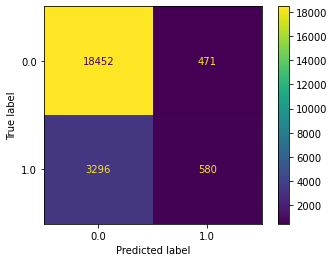

In [20]:
plot_confusion_matrix(clf, X_test, y_test, labels=clf.classes_)

In [23]:
clr = classification_report(y_test, y_pred)
print(clr)

              precision    recall  f1-score   support

         0.0       0.85      0.98      0.91     18923
         1.0       0.55      0.15      0.24      3876

    accuracy                           0.83     22799
   macro avg       0.70      0.56      0.57     22799
weighted avg       0.80      0.83      0.79     22799



# Conclusion

### We can see that for target value "0", the model is doing good but for "1", it is failing to predict due to class imbalance.

- MCC and f1-score are better to evaluate models when there is a class imbalance in the data.

- MCC is one of the best evaluation metric for "Binary Classification problem"

#### The Matthews correlation coefficient (MCC), instead, is a more reliable statistical rate which produces a high score only if the prediction obtained good results in all of the four confusion matrix categories (true positives, false negatives, true negatives, and false positives), proportionally both to the size of positive elements and the size of negative elements in the dataset.

<a href="https://ibb.co/HDXNgF1"><img src="https://i.ibb.co/jvHV46B/4-Table2-1.png" alt="4-Table2-1" border="0"></a>

<a href="https://imgbb.com/"><img src="https://i.ibb.co/bBtvLG9/download.png" alt="download" border="0"></a>